In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Modélisation
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

#Evaluate
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Données manquantes : interpolation

In [7]:
df_inter = pd.read_csv('../data/interpolation_linear.csv', delimiter=",")

In [8]:
df_inter.DateTime = pd.to_datetime(df_inter.DateTime,format="%Y-%m-%d %H:%M:%S")

In [9]:
df_inter  = df_inter.set_index('DateTime')

# Consommation totale par HEURE

In [10]:
df_heure = df_inter.copy()
df_final = df_heure.resample('H').sum()

# Division dataset train - test

In [11]:
df_final

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,103.554,3.684,14224.18,433.0,0.0,0.0,772.0
2010-11-26 18:00:00,94.408,3.222,14251.91,397.2,0.0,0.0,0.0
2010-11-26 19:00:00,99.560,3.602,14204.46,423.4,0.0,4.0,0.0


In [12]:
y = df_final.Global_active_power

In [13]:
y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

# Scaling : MinMaxScaler()

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

In [14]:
# prepare data for normalization
values = y_train.values
values = values.reshape((len(values), 1)) # OU values.reshape(-1, 1))
values_test = y_test.values
values_test = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
normalized_train = scaler.transform(values)
normalized_test = scaler.transform(values_test)

# Data Generator

In [17]:
train_generator = TimeseriesGenerator(normalized_train, normalized_train, length=240, batch_size=128)
test_generator = TimeseriesGenerator(normalized_test, normalized_test, length=240, batch_size=128)

In [18]:
# changer la taille de batch size : il y a que 32 segments ! Au moins 100 !
# représentation des segments 

In [21]:
train_generator[0]

(array([[[0.37438373],
         [0.54504495],
         [0.50900588],
         ...,
         [0.57524755],
         [0.38927787],
         [0.51685172]],
 
        [[0.54504495],
         [0.50900588],
         [0.48854974],
         ...,
         [0.38927787],
         [0.51685172],
         [0.50001036]],
 
        [[0.50900588],
         [0.48854974],
         [0.45559722],
         ...,
         [0.51685172],
         [0.50001036],
         [0.48515246]],
 
        ...,
 
        [[0.42147429],
         [0.48545283],
         [0.53623068],
         ...,
         [0.36130215],
         [0.59528421],
         [0.38175312]],
 
        [[0.48545283],
         [0.53623068],
         [0.54719932],
         ...,
         [0.59528421],
         [0.38175312],
         [0.58085615]],
 
        [[0.53623068],
         [0.54719932],
         [0.45598562],
         ...,
         [0.38175312],
         [0.58085615],
         [0.563818  ]]]),
 array([[0.50001036],
        [0.48515246],
        [0.

In [20]:
train_generator.__getitem__(0)

(array([[[0.37438373],
         [0.54504495],
         [0.50900588],
         ...,
         [0.57524755],
         [0.38927787],
         [0.51685172]],
 
        [[0.54504495],
         [0.50900588],
         [0.48854974],
         ...,
         [0.38927787],
         [0.51685172],
         [0.50001036]],
 
        [[0.50900588],
         [0.48854974],
         [0.45559722],
         ...,
         [0.51685172],
         [0.50001036],
         [0.48515246]],
 
        ...,
 
        [[0.42147429],
         [0.48545283],
         [0.53623068],
         ...,
         [0.36130215],
         [0.59528421],
         [0.38175312]],
 
        [[0.48545283],
         [0.53623068],
         [0.54719932],
         ...,
         [0.59528421],
         [0.38175312],
         [0.58085615]],
 
        [[0.53623068],
         [0.54719932],
         [0.45598562],
         ...,
         [0.38175312],
         [0.58085615],
         [0.563818  ]]]),
 array([[0.50001036],
        [0.48515246],
        [0.

In [19]:
x, y = train_generator[0]
print(x.shape)
print(y.shape)

(100, 240, 1)
(100, 1)


# Modelisation

In [60]:
model = Sequential()
model.add(InputLayer(input_shape=(train_generator.length,1)))
model.add(SimpleRNN(30, activation="relu"))
model.add(Dense(1))

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [64]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
750/750 [==============================] - 48s 63ms/step - loss: 0.0096 - mae: 0.0684 - val_loss: 0.0095 - val_mae: 0.0667
Epoch 2/10
750/750 [==============================] - 47s 63ms/step - loss: 0.0095 - mae: 0.0679 - val_loss: 0.0095 - val_mae: 0.0649
Epoch 3/10
750/750 [==============================] - 48s 63ms/step - loss: 0.0094 - mae: 0.0668 - val_loss: 0.0091 - val_mae: 0.0657
Epoch 4/10
750/750 [==============================] - 48s 64ms/step - loss: 0.0091 - mae: 0.0656 - val_loss: 0.0088 - val_mae: 0.0636
Epoch 5/10
750/750 [==============================] - 47s 62ms/step - loss: 0.0093 - mae: 0.0669 - val_loss: 0.0089 - val_mae: 0.0648
Epoch 6/10
750/750 [==============================] - 47s 63ms/step - loss: 0.0089 - mae: 0.0649 - val_loss: 0.0086 - val_mae: 0.0632
Epoch 7/10
750/750 [==============================] - 47s 63ms/step - loss: 0.0093 - mae: 0.0667 - val_loss: 0.0088 - val_mae: 0.0637
Epoch 8/10
750/750 [==============================] - 48s 64ms

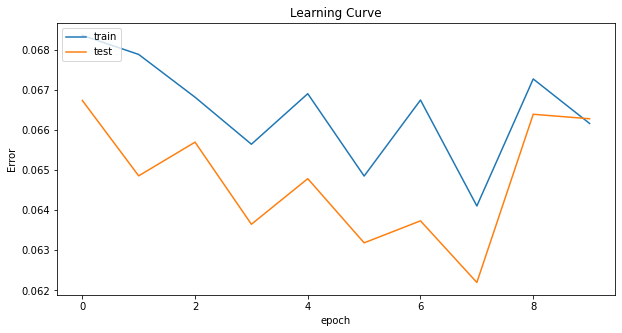

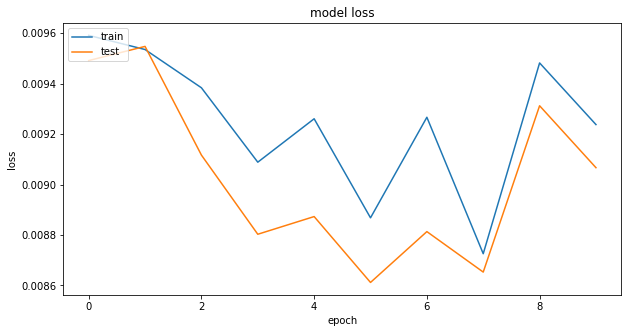

In [74]:
plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Learning Curve')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
#Enregistrer le modèle
# model.save('models/modelRNN10epochs240sequence')
#Récupérer le modèle :
# reconstructed_model = tf.keras.models.load_model("models/model")

INFO:tensorflow:Assets written to: models/modelRNN10epochs240sequence\assets


# Predictions

In [67]:
import random

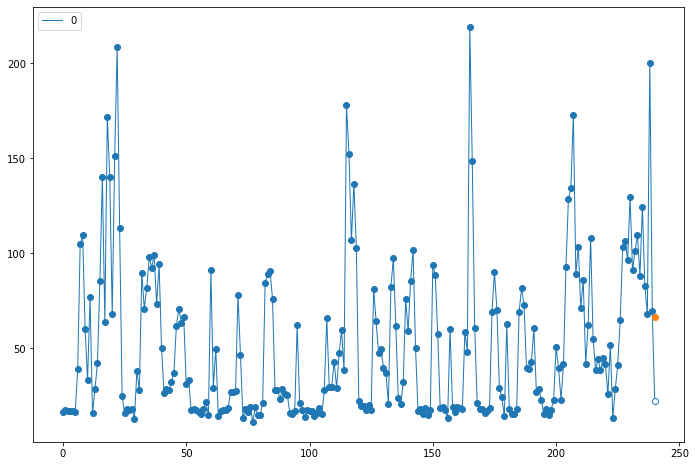

Différence prédiction-réalité : 44.39518737792969 KWH


In [155]:
s=random.randint(0,len(normalized_test)-train_generator.length) #sélection d'une séquence aléatoire
sequence = normalized_test[s:s+train_generator.length]
sequence_true = normalized_test[s:s+train_generator.length+1]

sequence = np.asarray(sequence).reshape(-1, 1)

pred = model.predict(np.array([sequence]))

# plot_multivariate_serie(sequence_true, predictions=pred,columns=1)

#Denormalisation des données
inversed_sequence_true = scaler.inverse_transform(sequence_true)
inversed_pred = scaler.inverse_transform(pred)

plot_multivariate_serie(inversed_sequence_true, predictions=inversed_pred,width=14, height=8)

delta=abs(inversed_sequence_true[-1]-inversed_pred[-1])
print(f'Différence prédiction-réalité : {delta[0]} KWH')

# Predictions sur plusieurs pas de temps

In [157]:
def get_prediction(dataset, model, iterations,sequence_len):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = scaler.inverse_transform(sequence_true)
    pred          = scaler.inverse_transform(pred)

    return sequence_true,pred

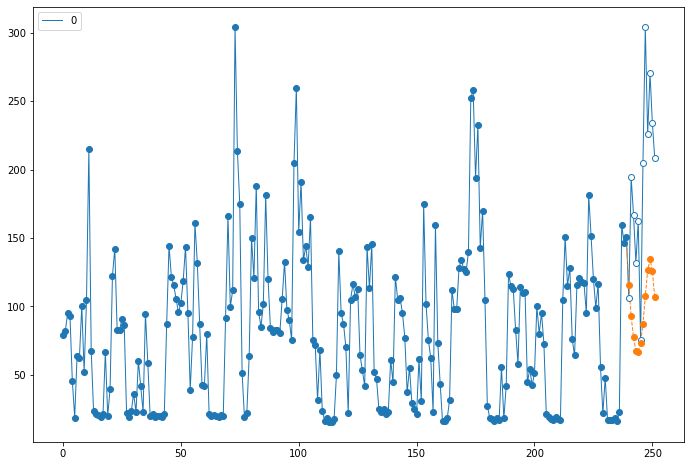

In [160]:
sequence_true_it, pred_it = get_prediction(normalized_test,model=model,iterations=12,sequence_len=train_generator.length)

plot_multivariate_serie(sequence_true_it, predictions=pred_it,width=14, height=8)

In [170]:
val_mae = 0.0663
val_mae = np.asarray(val_mae).reshape(1, -1)

In [171]:
scaler.inverse_transform(val_mae)

array([[33.0445296]])